---
### The Objective
The main objective is to systematically identify fraudulent transactions by exploring building a model to predict whether a user’s activity is fraudulent.

#### Summary of Data
1. user_id: Unique user ID
2. signup_time: The time when the user created their account (GMT time)
3. purchase_time: The time when the user bought the item (GMT time)
4. purchase_value: The cost of the item purchased (USD)
5. device_id: The device id. You can assume that it is unique by device. (If two transactions have the same device ID that means that the same physical device was used to purchase)
6. source: User marketing channel: ads, SEO, direct
7. browser: The browser used by the user.
8. sex: User sex: Male/Female
9. age: user age
10. ip_address: user numeric IP address
11. class: This is the target variable. Fraudulent activities is tagged as ‘1’, whereas non-fraudulent activities are tagged as ‘0’

In [1]:
import pandas as pd;
import numpy as np;
import datetime;
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder;
from sklearn.preprocessing import OneHotEncoder;
from sklearn.model_selection import train_test_split;
from sklearn import metrics;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import roc_curve;



In [2]:
data_1 = pd.read_csv("Fraud_Data.csv");
data_2 = pd.read_csv("IpAddress_to_Country.csv");

---
### Data Exploration (Part I)
We are presented with two datasets which I have defined as data_1 and data_2. File data_1 holds most of the data. File data_2 also holds information about the country of origin of the transaction which is also valuable. We must linked the two datasets with the with the IP from data_1 and the IP ranges from data_2.

In [3]:
data_1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data_2.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


---
## Pre-Processing Data
It is clear from just observation that we cannot create a usuable model based on the given data.
For us to build a predictive model, we need numerical inputs. Columns that contain categorical data (non-numeric) must be converted into numerical but logical numbers.

#### [1] Defining a New Dataset
We will define a new empty dataset called "new_data" for our model to build upon along with certain features that will be the columns of the new dataset.

In [5]:
new_data = pd.DataFrame();
country = [];
difference_time = [];

#### [2] Time Formatting
This will help us access the time stamp of the data more easily.

In [6]:
data_1['signup_time'] = pd.to_datetime(data_1.signup_time);
data_1['purchase_time'] = pd.to_datetime(data_1.purchase_time);

#### [3] Labeling IP and IP Ranges

In [7]:
ip_actual = np.array(data_1['ip_address']);
ip_lower = np.array(data_2["lower_bound_ip_address"]);
ip_upper = np.array(data_2["upper_bound_ip_address"]);

#### [4] Defining a Label Encoding Function
A Label Encoding function is a very powerful tool that allows us to take any column in a dataset and transform categorical data into unique integer values.

In [8]:
def label_encode(values):
    
    label_encoder = LabelEncoder();
    integer_encoded = label_encoder.fit_transform(values);
    
    return(integer_encoded);

#### [5] Defining an IP Search Function
This function will help us jointhe two given datasets.

In [9]:
def country_by_ip(ip_index):
    
    location = np.where(np.logical_and(ip_lower <= ip_actual[ip_index], ip_actual[ip_index] <= ip_upper));
    
    return location;

#### [6] Defining a Suspicious Activity Function
This function will find the time difference (in minutes) between an account creation and a purchase. A short time difference can be more telling than using the literal time of account creation and purchase information as.

In [10]:
def time_difference(index):
    
    difference = data_1['purchase_time'][index]-data_1['signup_time'][index];
    total_difference_in_minutes = round(difference.days*1440 + difference.seconds/60);
    
    return total_difference_in_minutes;

---
## Feature Engineering
We will now apply our preproccessing tools and apply it to build on the new dataset we created earlier by filling in the data.

#### [1] Applying IP Search Function
We will not apply the IP Search function by looping through the entire dataset once that will match the transaction with the corresponding country. If a specific country is not listed, then it will be listed as "Other". This information will be stored in our list "country" we have created earlier.

(Note: Est~ 34 seconds runtime on Intel i9 9900k (8C/16T) processor @ stock speeds)

In [11]:
for i in range(0, len(data_1)):
    if (country_by_ip(i)[0]).size > 0:
        country.append(data_2['country'][int(country_by_ip(i)[0])]);
    else:
        country.append("Other");

#### [2] Applying Suspicious Activity Function
This will loop through the entire dataset and export a list of the total time that have passed (in minutes) between each account creation and transaction.

In [12]:
for i in range(0,len(data_1)):
    difference_time.append(time_difference(i)); 

#### [3] Applying Label Encode Function 
We will now change all once previously unusable categorical data into a numerical value for our new dataset.

In [13]:
new_source = label_encode(data_1['source']); 
new_browser = label_encode(data_1['browser']);
new_device_id = label_encode(data_1['device_id']); 
new_sex = label_encode(data_1['sex']); 
new_country = label_encode(country);

#### [4] Filling New Dataset
We will now fill in our new dataset we created earlier with our new usuable data.

In [14]:
new_data['user_id'] = data_1['user_id'];
new_data['country'] = new_country;
new_data['purchase_value'] = data_1['purchase_value'];
new_data['age'] = data_1['age']; 
new_data['age'] = data_1['age'];
new_data['ip_address'] = data_1['ip_address'];


#### [5] Reusing Old Data
Fortunately some data from the original dataset were already numeric. We can reuse this information without changing it by copying it over directly into the new dataset.

In [15]:
new_data['source'] = new_source; 
new_data['browser'] = new_browser;
new_data['device_id'] = new_device_id; 
new_data['difference_time'] = difference_time;

---
### Data Exploration (Part II)
We can now observe that our new dataset is comprised of only numerical values.

In [16]:
new_data.head()

,user_id,country,purchase_value,age,ip_address,source,browser,device_id,difference_time
0,22058,84,34,39,7.327584e+08,2,0,89215,75111
1,333320,172,16,53,3.503114e+08,0,0,24078,299
2,1359,172,15,53,2.621474e+09,2,3,131216,0
3,150084,126,44,41,3.840542e+09,2,4,3977,8201
4,221365,172,39,45,4.155831e+08,0,4,68757,72691


### Visualization

In [17]:
data_1['country'] = country
fraud_actual = pd.DataFrame(data_1.loc[data_1['class'] == 1]);

##### As we can see, most of the fraudulant transactions are cheaper purchases mostly between 9 to 50 (dollars?)

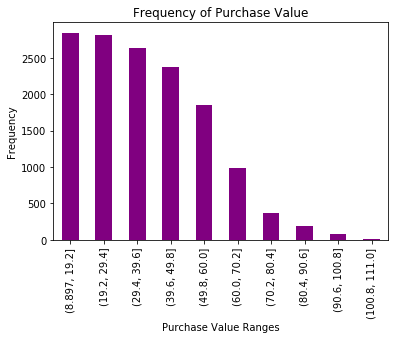

In [18]:
fraud_actual['purchase_value'].value_counts(bins = 10).plot(kind = 'bar', color ='purple', stacked=True);
plt.xlabel('Purchase Value Ranges');
plt.ylabel('Frequency');
plt.title('Frequency of Purchase Value');

##### Chrome is the most used browser for fraudulant activities

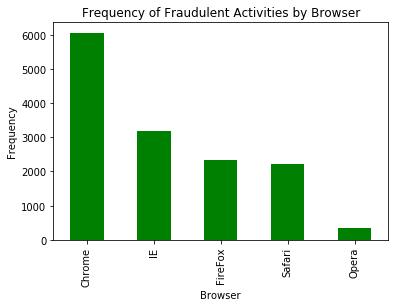

In [19]:
fraud_actual['browser'].value_counts().plot(kind = 'bar', color ='green');
plt.xlabel('Browser');
plt.ylabel('Frequency');
plt.title('Frequency of Fraudulent Activities by Browser');

##### Ads and SEO are the two leading sources of fradulant activies.

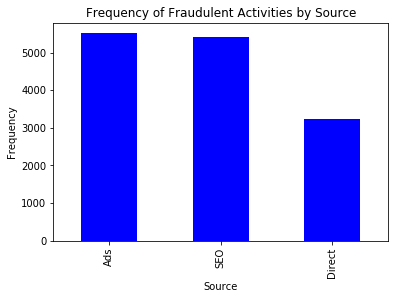

In [20]:
fraud_actual['source'].value_counts().plot(kind = 'bar', color ='blue');
plt.xlabel('Source');
plt.ylabel('Frequency');
plt.title('Frequency of Fraudulent Activities by Source');

##### About 60% of all the fradulant activities are performed by males and 40% females.

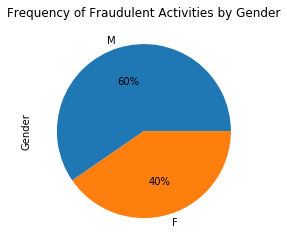

In [21]:
fraud_actual['sex'].value_counts().plot(kind = 'pie', label = 'Gender', autopct = '%1.0f%%');
plt.title('Frequency of Fraudulent Activities by Gender');

##### Ranking in the top 10 countries from this dataset, United States is by far the leading country for most fraudulant activities.

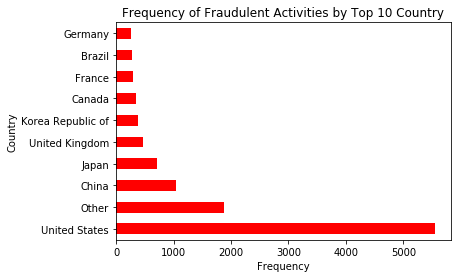

In [22]:
fraud_actual['country'].value_counts()[:10].plot(kind = 'barh', color ='red');
plt.xlabel('Frequency');
plt.ylabel('Country');
plt.title('Frequency of Fraudulent Activities by Top 10 Country');

#### [1] Defining Features and Targets
We will now split our data into two part. "X" being our features (should be the same as new_data) and "y" being our target variables being "0" or "1" that corresponds to "No Fraud" or "Fraud" respectively.

In [23]:
X = new_data;
y = data_1.loc[:, data_1.columns == 'class'];

In [24]:
X.head()

,user_id,country,purchase_value,age,ip_address,source,browser,device_id,difference_time
0,22058,84,34,39,7.327584e+08,2,0,89215,75111
1,333320,172,16,53,3.503114e+08,0,0,24078,299
2,1359,172,15,53,2.621474e+09,2,3,131216,0
3,150084,126,44,41,3.840542e+09,2,4,3977,8201
4,221365,172,39,45,4.155831e+08,0,4,68757,72691


In [25]:
y.head()

,class
0,0
1,0
2,1
3,0
4,0


---
## Processing Data
We will now apply our finalized data to produce a predictive model.

#### [1] Train - Test - Split
The "Training" data is use to develop the model.
The "Testing" data is used as unseen data and will be the data that is used to test the accuracy of the model.
The "Splitting" portion is arbitrary but a general 80% of data for training and 20% of data for testing is standard.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2);

#### [2] Model Selection
There are several common classification algorithms. For simplicity, we will consider just one algorithm for this case study.

   Descision Trees (Random Forest) - A highly accurate algorithm and is flexible. It's classification power is not limited to      binary outcomes like some others like Logistic Regression or Naive Bayes. It is capable of multivariate classification.        Support Vector Machines algorithm is another popular algorithm however its memory consumption is computationally expensive. 
   We will show the power and versatility of the Random Forest algorithm when applied to a binary classification problem.

In [27]:
rf_model = RandomForestClassifier(n_estimators = 10, max_depth = None, min_samples_split = len(np.unique(y)), random_state = 0);
rf_model.fit(X_train, y_train.values.ravel());

In [28]:
def accuracy(model):
    
    acc = metrics.accuracy_score(y_test, model);
    
    print("Accuracy is : " + str(acc));

In [29]:
def randomforest(dataset):
    
    predictions = rf_model.predict(dataset);
    
    return predictions;

### Results
The Random Forest algorithm used has produced an accuracy of 0.954. 
This means our model has correctly predicted 95.4% of the testing data.

In [30]:
y_pred = randomforest(X_test);
accuracy(y_pred);

Accuracy is : 0.9539754491612348


Our confusion matrix shows that our model has correctly predicted 27293 true "No Fraud" and 1385 true "Fraud" cases. But has incorrectly predicted 1539 false "No Fraud" and 6 false "Fraud" cases.

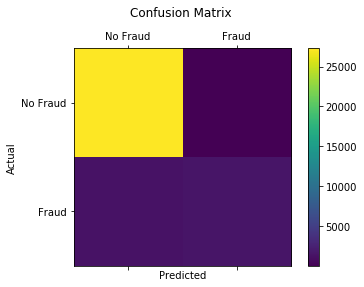

          No Fraud  Fraud
No Fraud     27293      6
Fraud         1385   1539


In [31]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = ['No Fraud',"Fraud"], index = ["No Fraud","Fraud"]);
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(cm);
plt.title('Confusion Matrix \n');
fig.colorbar(cax);
labels = ["No Fraud","Fraud"];
#ax.set_xticklabels([''] + labels);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.show();
print(cm);